<a href="https://colab.research.google.com/github/alejandroariaszuluaga/analisis_senales/blob/main/tarea7_AISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 7 AISS**

## **Punto 1**

El archivo datosIris.txt contiene 150 observaciones del largo y ancho de los sépalos de flores tipo
Iris. Estos datos son reales obtenidos en el repositorio UCI (http://archive.ics.uci.edu/ml/datasets/iris).

Una forma de cargar los archivos es usando `files.upload()`
Aquí se debe subir el archivo llamado `datosIris.txt`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from scipy.stats import multivariate_normal
import math

In [ ]:
from google.colab import files
files.upload()

{}

Otra forma, la cual se puede usar si se tiene el archivo en Google drive en el directorio `/content/gdrive/MyDrive/Colab Notebooks/AISS/` es importándolos desde allí directamente.

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import pandas as pd

irisDF = pd.read_csv (r'/content/gdrive/MyDrive/Colab Notebooks/AISS/datosIris.txt', sep='   ', header = None, names = ['x1', 'x2'])
irisDF.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,x1,x2
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


### A) Grafique los 150 puntos y comente la distribución de los datos.

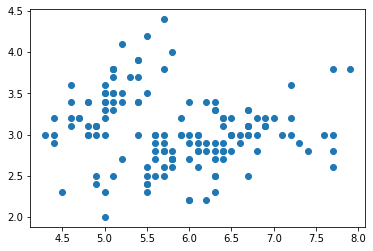

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(irisDF.values[:,0], irisDF.values[:,1])


### Implemente el algoritmo EM

In [6]:
muestras = irisDF.values

In [7]:
def cov_gauss(XY,mu):
  suma = np.zeros([2,2])
  for i in range(len(XY)):
    t = XY[i]-mu
    prod = np.array([[t[0]**2,t[0]*t[1]],[t[1]*t[0],t[1]**2]])
    suma += prod
  return (1/len(XY))*suma

In [8]:
mu_x = sum(muestras[:,0])/len(muestras)
mu_y = sum(muestras[:,1])/len(muestras)
mu_xy = np.array([mu_x,mu_y])
cov_xy = cov_gauss(muestras,mu_xy)
print(mu_xy)
print(cov_xy)

[5.84333333 3.054     ]
[[ 0.68112222 -0.03900667]
 [-0.03900667  0.18675067]]


In [9]:
def pdf_z(x,y,C_Z,mu_Z):
  z = np.array([x,y])
  p = ( 1 / ( 2 * np.pi * np.linalg.det(C_Z)**(1/2) ) ) * np.exp( - ( (np.transpose(z-mu_Z)).dot( np.linalg.inv(C_Z) ).dot( z-mu_Z ) ) / 2 )
  return p

In [10]:
x = np.linspace(0, 10, 400)
y = np.linspace(0, 10, 400)

# Creación de una matriz que combina los valores del rango de X y Y
X,Y = np.meshgrid(x, y)

# Los valores de la PDF se guardarán en la siguiente matriz
Z = np.zeros( (len(X[0]), len(Y[0])) )

# Se evalúa la función definida anteriormente en cada uno de los puntos
for i in range(len(X[0])):
  for j in range(len(Y[0])):
    Z[i,j] = pdf_z(X[i,j],Y[i,j],cov_xy,mu_xy)

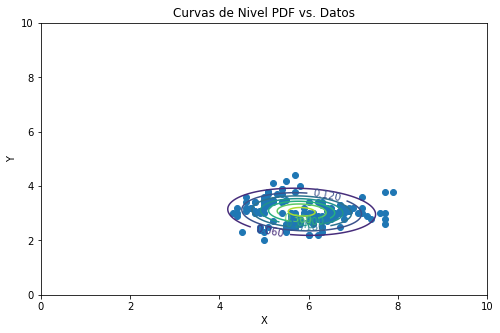

In [11]:
# Se grafican las curvas de nivel de la función definida
plt.figure(figsize=(8,5))
contours = plt.contour(X, Y, Z)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1])
# Accesorios de la figura
plt.title('Curvas de Nivel PDF vs. Datos')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Algoritmo EM

In [12]:
def func_obj(XY,alpha,mu,cov):
  s1 = 0
  for i in range(len(XY)):
    s2 = 0
    for j in range(len(alpha)):
      s2 += alpha[j]*pdf_z(XY[i][0],XY[i][1],cov[j],mu[j])
    s1 += np.log(s2)
  return s1

def func_gamma(X_Y,alpha,mu,cov,k):
  suma = 0
  for i in range(len(alpha)):
    suma += alpha[i]*pdf_z(X_Y[0],X_Y[1],cov[i],mu[i])
  return alpha[k]*pdf_z(X_Y[0],X_Y[1],cov[k],mu[k])/suma

def func_muk(XY,gamma,Nk,k):
  s = np.zeros(2)
  for i in range(len(XY)):
    s += gamma[k][i]*XY[i]
  return s/Nk

def func_covk(XY,mu,gamma,Nk,k):
  suma = np.zeros([2,2])
  for i in range(len(XY)):
    t = XY[i]-mu[k]
    prod = np.array([[t[0]**2,t[0]*t[1]],[t[1]*t[0],t[1]**2]])
    suma += prod*gamma[k][i]
  suma = suma/Nk
  return suma

In [13]:
def algoritmo_EM(XY,alpha_0,cov_0,mu_0):
  alpha = alpha_0
  cov = cov_0
  mu = mu_0
  
  alpha_acum = [alpha]
  cov_acum = [cov]
  mu_acum = [mu]

  func_max = func_obj(XY,alpha,mu,cov)
  cond1 = True
  cond2 = 0
  while cond1 and (cond2<17):
    try:
      # E-Step
      gamma = np.zeros((len(alpha),len(XY)))
      for i in range(len(alpha)):
        for j in range(len(XY)):
          gamma[i][j] = func_gamma(XY[j],alpha,mu,cov,i)
      
      # M-Step
      # Estimado N_k
      N_k = np.zeros(len(alpha))
      for i in range(len(alpha)):
        N_k[i] = sum(gamma[i])

      # Estimado mu_k
      mu_k = np.zeros((len(alpha),2))
      for i in range(len(alpha)):
        mu_k[i] = func_muk(XY,gamma,N_k[i],i)
      
      # Estimando a_k
      a_k = N_k/len(XY)
      # Estimando C_k
      C_k = np.zeros((len(alpha),2,2))
      for i in range(len(alpha)):
        C_k[i] = func_covk(XY,mu,gamma,N_k[i],i)

      # Actualización de los parámetros
      alpha = a_k
      mu = mu_k
      cov = C_k

      alpha_acum.append(alpha)
      cov_acum.append(cov)
      mu_acum.append(mu)
      
      # Evalua la condicion para parar el ciclo
      f = func_obj(XY,alpha,mu,cov)
      cond1 = abs(func_max - f) > 0.001
      cond2 += 1
      func_max = f
    except Exception as e:
      print(cond2)
      print(f'Something happened because {e}, will break cycle')
      break
  print(cond2)
  return alpha_acum,cov_acum,mu_acum

In [14]:
# Condiciones iniciales
mu_0 = np.array([1,1])
C_Z0 = np.array([[1,0],[0,1]])

alpha = np.array([0.3,0.3,0.6])
cov = np.array([C_Z0,2*C_Z0,C_Z0])
mu = np.array([mu_0,2*mu_0,mu_0])
alpha_acum_3G, cov_acum_3G, mu_acum_3G = algoritmo_EM(muestras,alpha,cov,mu)

alpha = np.array([0.3,0.3,0.6,0.1])
cov = np.array([C_Z0,2*C_Z0,3*C_Z0,C_Z0])
mu = np.array([mu_0,3*mu_0,mu_0,2*mu_0])
alpha_acum_4G, cov_acum_4G, mu_acum_4G = algoritmo_EM(muestras,alpha,cov,mu)

17
17


In [15]:
# Los valores de la PDF se guardarán en la siguiente matriz
Z_3G1 = np.zeros( (len(X[0]), len(Y[0])) )
Z_3G2 = np.copy(Z_3G1)
Z_3G3 = np.copy(Z_3G1)
Z_3G4 = np.copy(Z_3G1)
Z_4G1 = np.zeros( (len(X[0]), len(Y[0])) )
Z_4G2 = np.copy(Z_4G1)
Z_4G3 = np.copy(Z_4G1)
Z_4G4 = np.copy(Z_4G1)

iter_3G = len(alpha_acum_3G)
iter_4G = len(alpha_acum_4G)

# Se evalúa la función definida anteriormente en cada uno de los puntos
for i in range(len(X[0])):
  for j in range(len(Y[0])):    
    ## Para cuatro distintas iteraciones de EM de 3 gaussianas
    p1 = alpha_acum_3G[1][0]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[1][0],mu_acum_3G[1][0])
    p2 = alpha_acum_3G[1][1]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[1][1],mu_acum_3G[1][1])
    p3 = alpha_acum_3G[1][2]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[1][2],mu_acum_3G[1][2])
    Z_3G1[i,j] = p1 + p2 + p3
    p1 = alpha_acum_3G[iter_3G//3][0]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[iter_3G//3][0],mu_acum_3G[iter_3G//3][0])
    p2 = alpha_acum_3G[iter_3G//3][1]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[iter_3G//3][1],mu_acum_3G[iter_3G//3][1])
    p3 = alpha_acum_3G[iter_3G//3][2]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[iter_3G//3][2],mu_acum_3G[iter_3G//3][2])
    Z_3G2[i,j] = p1 + p2 + p3
    p1 = alpha_acum_3G[2*iter_3G//3][0]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[2*iter_3G//3][0],mu_acum_3G[2*iter_3G//3][0])
    p2 = alpha_acum_3G[2*iter_3G//3][1]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[2*iter_3G//3][1],mu_acum_3G[2*iter_3G//3][1])
    p3 = alpha_acum_3G[2*iter_3G//3][2]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[2*iter_3G//3][2],mu_acum_3G[2*iter_3G//3][2])
    Z_3G3[i,j] = p1 + p2 + p3
    p1 = alpha_acum_3G[-1][0]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[-1][0],mu_acum_3G[-1][0])
    p2 = alpha_acum_3G[-1][1]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[-1][1],mu_acum_3G[-1][1])
    p3 = alpha_acum_3G[-1][2]*pdf_z(X[i,j],Y[i,j],cov_acum_3G[-1][2],mu_acum_3G[-1][2])
    Z_3G4[i,j] = p1 + p2 + p3

    ## Para cuatro distintas iteraciones de EM de 4 gaussianas
    p1 = alpha_acum_4G[1][0]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[1][0],mu_acum_4G[1][0])
    p2 = alpha_acum_4G[1][1]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[1][1],mu_acum_4G[1][1])
    p3 = alpha_acum_4G[1][2]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[1][2],mu_acum_4G[1][2])
    p4 = alpha_acum_4G[1][3]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[1][3],mu_acum_4G[1][3])
    Z_4G1[i,j] = p1 + p2 + p3 + p4
    p1 = alpha_acum_4G[iter_4G//3][0]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[iter_4G//3][0],mu_acum_4G[iter_4G//3][0])
    p2 = alpha_acum_4G[iter_4G//3][1]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[iter_4G//3][1],mu_acum_4G[iter_4G//3][1])
    p3 = alpha_acum_4G[iter_4G//3][2]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[iter_4G//3][2],mu_acum_4G[iter_4G//3][2])
    p4 = alpha_acum_4G[iter_4G//3][3]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[iter_4G//3][3],mu_acum_4G[iter_4G//3][3])
    Z_4G2[i,j] = p1 + p2 + p3 + p4
    p1 = alpha_acum_4G[2*iter_4G//3][0]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[2*iter_4G//3][0],mu_acum_4G[2*iter_4G//3][0])
    p2 = alpha_acum_4G[2*iter_4G//3][1]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[2*iter_4G//3][1],mu_acum_4G[2*iter_4G//3][1])
    p3 = alpha_acum_4G[2*iter_4G//3][2]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[2*iter_4G//3][2],mu_acum_4G[2*iter_4G//3][2])
    p4 = alpha_acum_4G[2*iter_4G//3][3]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[2*iter_4G//3][3],mu_acum_4G[2*iter_4G//3][3])
    Z_4G3[i,j] = p1 + p2 + p3 + p4
    p1 = alpha_acum_4G[-1][0]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[-1][0],mu_acum_4G[-1][0])
    p2 = alpha_acum_4G[-1][1]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[-1][1],mu_acum_4G[-1][1])
    p3 = alpha_acum_4G[-1][2]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[-1][2],mu_acum_4G[-1][2])
    p4 = alpha_acum_4G[-1][3]*pdf_z(X[i,j],Y[i,j],cov_acum_4G[-1][3],mu_acum_4G[-1][3])
    Z_4G4[i,j] = p1 + p2 + p3 + p4

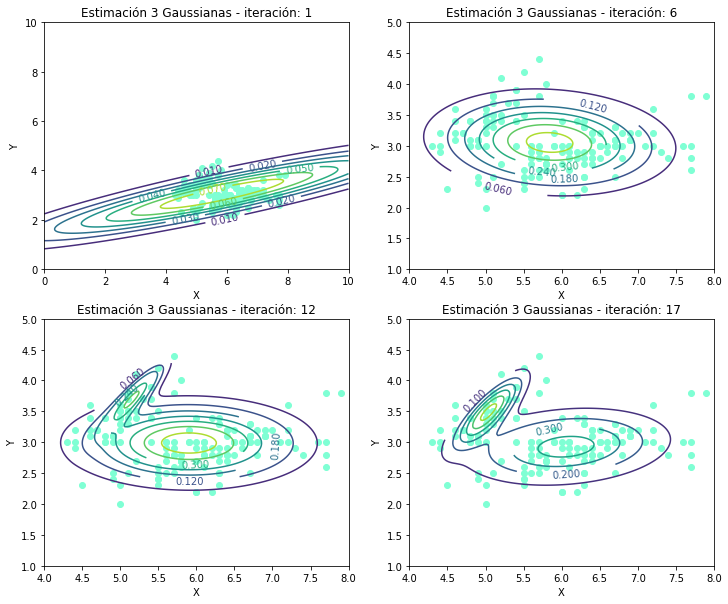

In [16]:
# Se grafican las curvas de nivel de la función definida
plt.figure(figsize=(12,10))
plt.subplot(221)
contours = plt.contour(X, Y, Z_3G1)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
# Accesorios de la figura
plt.title('Estimación 3 Gaussianas - iteración: 1')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(222)
contours = plt.contour(X, Y, Z_3G2)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
# Accesorios de la figura
plt.title('Estimación 3 Gaussianas - iteración: ' + str(iter_3G//3))
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(223)
contours = plt.contour(X, Y, Z_3G3)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 3 Gaussianas - iteración: ' + str(2*iter_3G//3))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(224)
contours = plt.contour(X, Y, Z_3G4)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 3 Gaussianas - iteración: ' + str(iter_3G-1))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

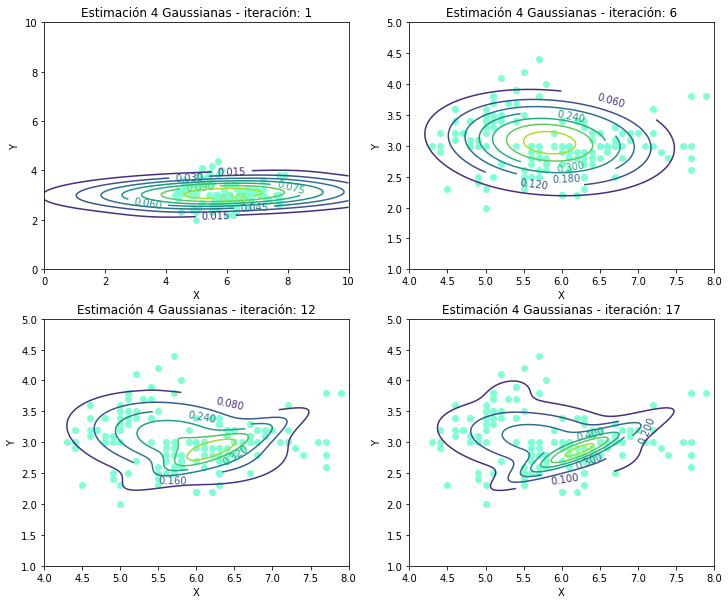

In [17]:
# Se grafican las curvas de nivel de la función definida
plt.figure(figsize=(12,10))
plt.subplot(221)
contours = plt.contour(X, Y, Z_4G1)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
# Accesorios de la figura
plt.title('Estimación 4 Gaussianas - iteración: 1')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(222)
contours = plt.contour(X, Y, Z_4G2)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 4 Gaussianas - iteración: ' + str(iter_3G//3))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(223)
contours = plt.contour(X, Y, Z_4G3)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 4 Gaussianas - iteración: ' + str(2*iter_4G//3))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(224)
contours = plt.contour(X, Y, Z_4G4)
plt.clabel(contours, inline=1, fontsize=10)
# Se grafican los datos reales
plt.scatter(muestras[:,0], muestras[:,1], color='aquamarine')
plt.xlim(left=4, right=8)
plt.ylim(bottom=1, top=5)
# Accesorios de la figura
plt.title('Estimación 4 Gaussianas - iteración: ' + str(iter_4G-1))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()